In [6]:
#Import tensorflow and numpy
import tensorflow as tf
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#Import keras models
from random import random
from numpy import array
from numpy import cumsum

from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
print(keras.__version__)

2.6.0


In [8]:
#Import scikit modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [9]:
#Import any other libraries needed
import math
import os
from datetime import datetime, date

# Read in Data

1. Mount Google Drive file system

In [ ]:
# from google.colab import drive # Hosting the file in Google Drive, need to mount the drive so it is accessible
# # Currently Google forces an authorisation code, local runtime would rectify this
# drive.mount('/content/gdrive', force_remount=True) #force_remount forces Google t

2. Read in SANReN sample data.

In [10]:
with open('SANREN_large.txt') as f:
  SANReN = f.readlines()
  
#Iterate through first 5 rows to ensure data has been read correctly. 
for i in range(5):
  print(SANReN[i])

Date first-seen          Duration Proto      Src IP Addr:Port          Dst IP Addr:Port   Flags Tos  Packets    Bytes      pps      bps    Bpp Flows

2020-07-04 20:10:06.480     1.223 TCP       146.231.4.0:47837 ->   155.232.240.0:443   .A....   0     4500   234000     3679    1.5 M     52     1

2020-07-04 20:09:01.555    78.205 TCP       196.24.45.0:443   ->   196.11.235.0:29108 .AP...   0    31000   46.5 M      396    4.8 M   1500     1

2020-07-04 20:10:01.690     5.307 TCP        146.230.0.0:6474  ->     196.24.45.0:443   .A....   0     1000    40000      188    60297     40     1

2020-07-04 20:09:23.019    43.982 TCP     197.102.66.0:443   ->   196.21.242.0:52855 .A....   0     2000    3.0 M       45   545677   1500     1



# ***Data Preprocessing***

3. Clean dataframe headers

In [11]:
headings_line = SANReN[0].split()
#Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[4:7] = [''.join(headings_line[4:7])]
#Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])]
#Remove 'Flags', 'Tos', and 'Flows'.
headings_line = headings_line[0:6] + headings_line[8:13]

4. Clean time-series data points

In [12]:
framedata = []
for i in range(1, 501):
  data_line = SANReN[i].split()

  if (data_line[11] == "M" and (data_line[14] == 'M' or data_line[14] == 'G')): #Bytes and BPS in megabytes
    #print("1 and 2") 
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    if (data_line[9] == 'G'):
      data_line[9] = float(data_line[9])*100000000 #Change G bytes into byte measurement. 
    else:
      data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
   
 
  elif (data_line[13] == 'M'): #BPS measured in megabytes
    #print("2")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  data_line  = np.asarray(data_line) #Turn each line into a NumPy array.
  framedata.append(data_line) #append each line to 'mother' array. 

5. Convert numpy array into pandas dataframe and add additional columns.
  - Day: gives the day of the week as an integer. Monday is 0 and Sunday is 6.

In [13]:
df = pd.DataFrame(np.array(framedata), columns=headings_line) #convert 2D numpy array framedata into pandas df. 
#df['Date'] = pd.to_datetime(df['Date'])

print(df) # Print data just to check it is formatted correctly.

           Date    first-seen Duration Proto     SrcIPAddr:Port  \
0    2020-07-04  20:10:06.480    1.223   TCP  146.231.4.0:47837   
1    2020-07-04  20:09:01.555   78.205   TCP    196.24.45.0:443   
2    2020-07-04  20:10:01.690    5.307   TCP   146.230.0.0:6474   
3    2020-07-04  20:09:23.019   43.982   TCP   197.102.66.0:443   
4    2020-07-04  20:10:07.007    0.000   TCP    196.24.45.0:443   
..          ...           ...      ...   ...                ...   
495  2020-07-04  20:09:52.711   23.846   TCP    196.24.45.0:443   
496  2020-07-04  20:10:10.890    0.000   TCP    10.47.3.0:61030   
497  2020-07-04  20:10:10.891    0.000  ICMP      196.24.45.0:0   
498  2020-07-04  20:10:10.905    5.986   TCP    196.24.45.0:443   
499  2020-07-04  20:10:10.912    0.000   TCP    196.24.45.0:443   

         DstIPAddr:Port Packets              Bytes   pps        bps   Bpp  
0     155.232.240.0:443    4500             234000  3679  1500000.0    52  
1    196.11.235.0:29108   31000         465

In [14]:
#Examining column headings
#print(df.columns)
#Examining all unique IP addresses in sample.
#print(pd.unique(df["SrcIPAddr:Port"]))

#Define all data types correctly. 
df = df.astype({"Date": np.datetime64})
df["Day"] = df['Date'].dt.dayofweek #Created Day variable. 
df = df.astype({'first-seen': np.datetime64})
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})

In [15]:
#display(df.dtypes)
# Dropping the non numeric variables for now, need to find a way to encode them. Suggested: one-hot encoding. Could also be done in scaling step. 
df = (df.drop(['Date', 'first-seen', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis = 1))
print(df.shape)

(500, 7)


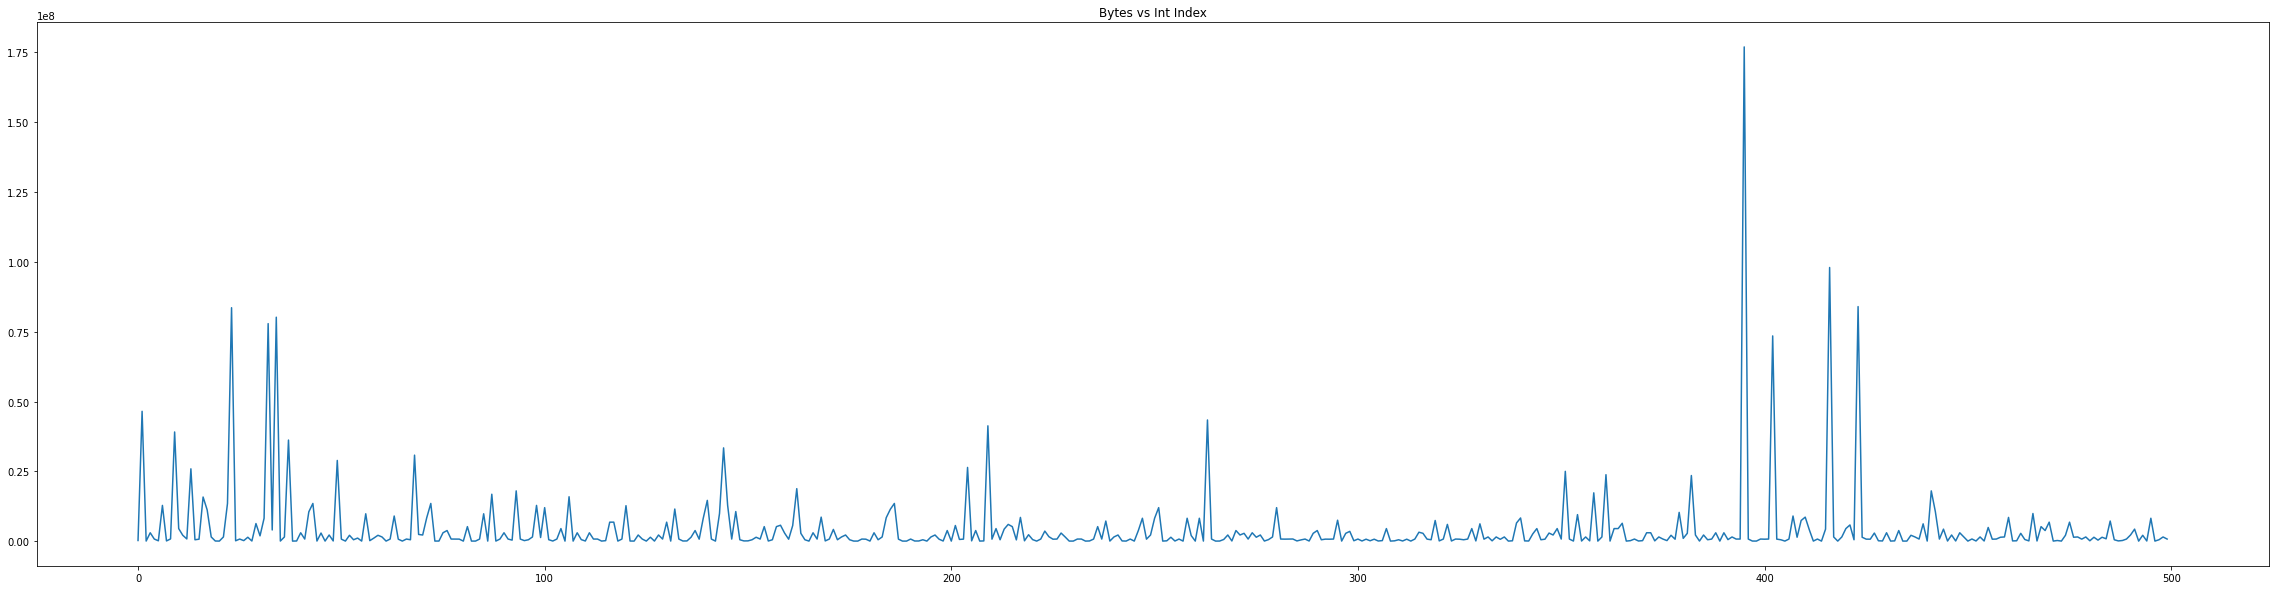

In [19]:
#A plot of Bytes vs time (treating bytes as target variable)
plt.figure(figsize=(40,10))
plt.title("Bytes vs Int Index")
plt.plot(df['Bytes'])

6. Split data into both training and test set. Use 80/20 split. 
   Decide later whether validation set or whether cross validation applied




In [20]:
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the sample.
train = df.iloc[:-test_size,:].copy()  #Not copying here threw an error. Must be careful not to keep two copies for memory reasons.
test = df.iloc[-test_size:,:].copy() 

X_train = train.drop('Bytes',axis=1).copy() #Drop target variable from training data. 
y_train = train[['Bytes']].copy() # The double brackets are to keep Bytes in a pandas dataframe format, otherwise it will be pandas Series.
print(X_train.shape, y_train.shape) #Check shape of training variables. 

# Output -> (400, 6) (400, 1)
# Output implies we have 400 examples, with 6 predictors and 1 predicted value 

(400, 6) (400, 1)


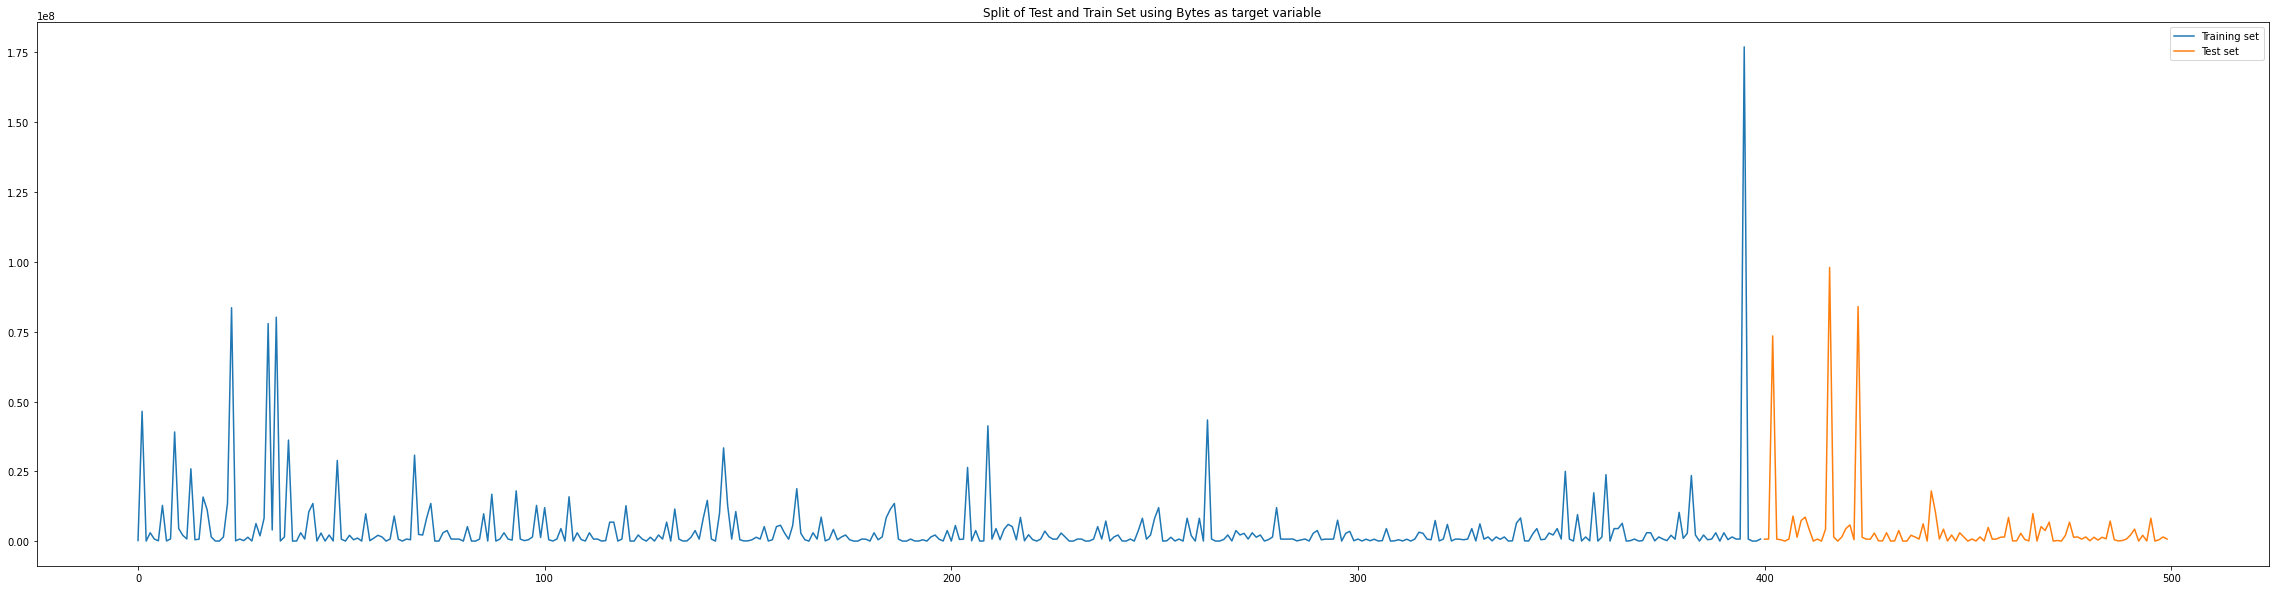

In [21]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as target variable")
plt.plot(train.index,train['Bytes'],label='Training set')
plt.plot(test.index,test['Bytes'],label='Test set')
plt.legend()

In [22]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scikit MinMixScaler allows all variables to be normalised between 0 and 1.
Xscaler.fit(X_train) #Compute the minimum and maximum to be used for later scaling
scaled_X_train = Xscaler.transform(X_train) #Scale features of X according to feature_range.

print(X_train.shape) #X_train shape is the same as earlier but now scaled. 
print(scaled_X_train) #Demonstrate normalised data. 


(400, 6)
[[4.35200342e-03 3.40425532e-02 1.47160000e-02 1.82282173e-03
  8.21917808e-03 0.00000000e+00]
 [2.78289801e-01 2.59574468e-01 1.58400000e-03 5.83302953e-03
  1.00000000e+00 0.00000000e+00]
 [1.88847769e-02 4.25531915e-03 7.52000000e-04 7.32737878e-05
  0.00000000e+00 0.00000000e+00]
 ...
 [2.51690271e-02 4.25531915e-03 5.64000000e-04 5.49787337e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.21917808e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]


In [23]:
Yscaler = MinMaxScaler(feature_range=(0, 1)) #apply same normalisation to response. 
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape) #Shape is constant. 
#scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)


scaled_y_train = np.insert(scaled_y_train, 0, 0)
#print(scaled_y_train)
scaled_y_train = np.delete(scaled_y_train, -1) #Why do we have to delete this?
#print(scaled_y_train)

(400, 1)
(400, 1)


In [24]:
n_input = 100 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

print(train_generator[0][0].shape)

(32, 100, 6)


# Simple LSTM Implementation

7. Defining the Keras model configuaration for Simple LSTM



In [25]:
simple_LSTM_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
simple_LSTM_model.add(LSTM(50, activation='sigmoid', input_shape=(n_input, n_features))) # Model is an LSTM, 150 is dimentionality of the output, activation function is sigmoid
simple_LSTM_model.add(Dense(1)) # Dense layer as the first layer of the model
simple_LSTM_model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) # Compile the model with the adam optimizer, loss measured in Mean Squarred Error and reporting on the accuracy of the model
# Adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.summary() # Print out a summary of the LSTM to check that it was compiled correctly 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


2021-08-19 15:31:35.509402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


8. Fit the data to the model and train. Generate a summary of the model and show training results

2021-08-19 15:31:41.364213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
10/10 [==============================] - 3s 46ms/step - loss: 0.1882 - accuracy: 0.0433
Epoch 2/30
10/10 [==============================] - 1s 50ms/step - loss: 0.0318 - accuracy: 0.0433
Epoch 3/30
10/10 [==============================] - 0s 45ms/step - loss: 0.0153 - accuracy: 0.0433
Epoch 4/30
10/10 [==============================] - 0s 46ms/step - loss: 0.0082 - accuracy: 0.0433
Epoch 5/30
10/10 [==============================] - 0s 47ms/step - loss: 0.0048 - accuracy: 0.0433
Epoch 6/30
10/10 [==============================] - 1s 61ms/step - loss: 0.0048 - accuracy: 0.0433
Epoch 7/30
10/10 [==============================] - 1s 63ms/step - loss: 0.0035 - accuracy: 0.0433
Epoch 8/30
10/10 [==============================] - 1s 65ms/step - loss: 0.0035 - accuracy: 0.0433
Epoch 9/30
10/10 [==============================] - 1s 57ms/step - loss: 0.0034 - accuracy: 0.0433
Epoch 10/30
10/10 [==============================] - 1s 50ms/step - loss: 0.0033 - accuracy: 0.0433
Epoch 11/

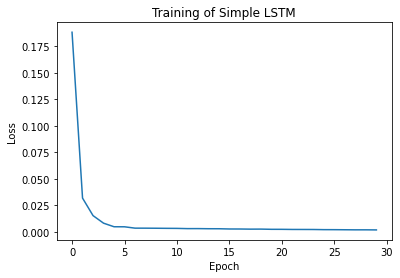

In [26]:
simple_LSTM_model.fit(train_generator, epochs=30, verbose = 1) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.title('Training of Simple LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

9. TESTING

In [27]:
X_test = test.drop('Bytes',axis=1).copy()
#print(X_test)
scaled_X_test = Xscaler.transform(X_test)
#print(scaled_X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=25, batch_size=b_size) #There are only 17 samples in the test set so it cannot look back.
print(test_generator[0][0].shape)

(32, 25, 6)


       y_true        y_pred
0    717000.0  9.139509e+06
1    700000.0  6.337435e+06
2   2900000.0  5.126442e+06
3    130000.0  5.558544e+06
4     66500.0  1.839387e+05
..        ...           ...
70  8200000.0 -1.720802e+06
71    24000.0  7.495452e+06
72   499000.0 -2.469258e+06
73  1500000.0  1.882068e+06
74   750000.0  4.035599e+06

[75 rows x 2 columns]


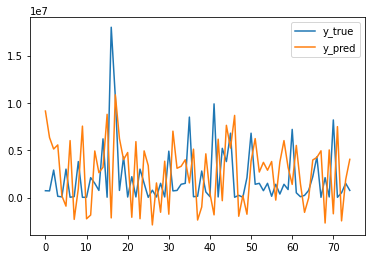

In [28]:
y_pred_scaled = simple_LSTM_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:],'y_pred':y_pred.ravel()})
simple_lstm_results.plot()
print(simple_lstm_results)

Predictions made in Megabytes

In [29]:
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:]/1000000,'y_pred':y_pred.ravel()/1000000})

In [ ]:
simple_lstm_results['residuals'] = np.square(simple_lstm_results.y_pred - simple_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
simple_LSTM_mse = simple_lstm_results.residuals.sum() * (1/len(simple_lstm_results))
print(np.round(simple_LSTM_mse, 3))

# Bidirectional LSTM Implementation

10. Defining the Keras model configuaration for Bidirectional LSTM



In [30]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
bidirectional_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
bidirectional_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False, activation="sigmoid"), input_shape=(n_input, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(loss='mse', optimizer='adam')

Epoch 1/30
10/10 - 3s - loss: 0.0760
Epoch 2/30
10/10 - 1s - loss: 0.0195
Epoch 3/30
10/10 - 1s - loss: 0.0122
Epoch 4/30
10/10 - 1s - loss: 0.0065
Epoch 5/30
10/10 - 1s - loss: 0.0059
Epoch 6/30
10/10 - 1s - loss: 0.0048
Epoch 7/30
10/10 - 1s - loss: 0.0049
Epoch 8/30
10/10 - 1s - loss: 0.0045
Epoch 9/30
10/10 - 1s - loss: 0.0044
Epoch 10/30
10/10 - 1s - loss: 0.0045
Epoch 11/30
10/10 - 1s - loss: 0.0043
Epoch 12/30
10/10 - 1s - loss: 0.0042
Epoch 13/30
10/10 - 1s - loss: 0.0040
Epoch 14/30
10/10 - 1s - loss: 0.0041
Epoch 15/30
10/10 - 1s - loss: 0.0038
Epoch 16/30
10/10 - 1s - loss: 0.0040
Epoch 17/30
10/10 - 0s - loss: 0.0037
Epoch 18/30
10/10 - 0s - loss: 0.0040
Epoch 19/30
10/10 - 1s - loss: 0.0037
Epoch 20/30
10/10 - 0s - loss: 0.0034
Epoch 21/30
10/10 - 1s - loss: 0.0034
Epoch 22/30
10/10 - 1s - loss: 0.0032
Epoch 23/30
10/10 - 0s - loss: 0.0036
Epoch 24/30
10/10 - 1s - loss: 0.0033
Epoch 25/30
10/10 - 1s - loss: 0.0033
Epoch 26/30
10/10 - 0s - loss: 0.0032
Epoch 27/30
10/10 - 0

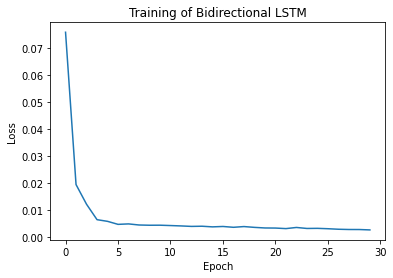

In [31]:
bidirectional_lstm_model.fit(train_generator, epochs=30, verbose=2)
loss_per_epoch = bidirectional_lstm_model.history.history['loss']
plt.title('Training of Bidirectional LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [ ]:
y_pred_scaled = bidirectional_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:],'y_pred':y_pred.ravel()})
print(bidirectional_lstm_results)
bidirectional_lstm_results.plot()

In [ ]:
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print(bidirectional_LSTM_mse)

Predictions made in megabytes

In [ ]:
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:]/1000000,'y_pred':y_pred.ravel()/1000000})

In [ ]:
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print(np.round(bidirectional_LSTM_mse, 3))

# Stacked LSTM Implementation

In [ ]:
stacked_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
stacked_lstm_model.add(LSTM(50, return_sequences=True, activation="sigmoid", input_shape=(n_input, n_features)))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:

stacked_lstm_model.fit(train_generator, epochs=30, verbose=2)
loss_per_epoch = stacked_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
y_pred_scaled = stacked_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:],'y_pred':y_pred.ravel()})
print(stacked_lstm_results)
stacked_lstm_results.plot()

In [ ]:
stacked_lstm_results['residuals'] = np.square(stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * (1/len(stacked_lstm_results))
print(stacked_LSTM_mse)

Predictions made in megabytes

In [ ]:
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[25:]/1000000,'y_pred':y_pred.ravel()/1000000})

In [ ]:
stacked_lstm_results['residuals'] = np.square(stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * (1/len(stacked_lstm_results))
print(np.round(stacked_LSTM_mse, 3))